In [2]:
#%reset -f
import glob, os, sys, io
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import pandas as pd
import numpy as np

from wavhandler import *
from utils import *
import multiprocessing
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
sn.set()

import logging
logger = logging.getLogger()
logger.propagate = False
logger.setLevel(logging.ERROR)
np.random.seed(0)

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import xgboost
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

In [3]:
df_mosquitos = pd.read_csv(TEMP_DATADIR+'mosquitos.csv', delimiter=';')

In [4]:
#bi_classes = ['LG_drosophila_10_09', 'LG_zapr_26_09']
#target_names = all_6
DATADIR = '/home/kalfasyan/data/insects/LG2/'
target_names = os.listdir(DATADIR)

X_names, y = get_data(filedir= DATADIR,
                      target_names=target_names, nr_signals=np.inf, only_names=True)

100%|██████████| 3/3 [00:00<00:00, 21.99it/s]


In [5]:
for i,t in enumerate(target_names):
    print(i,t)
print(target_names)

0 LG_drosophila_10_09
1 LG_suzukii_18_09_faulty
2 LG_zapr_26_09
['LG_drosophila_10_09', 'LG_suzukii_18_09_faulty', 'LG_zapr_26_09']


# Creating a dataframe of PSDs for all mosquito classes

In [6]:
%%time
X = make_df_parallel(names=X_names, setting='psd_dB')
df_concat = pd.DataFrame(X.T)
df_concat['label'] = y

# print(df_concat.label.value_counts())
# df_concat = df_concat[df_concat.label.isin([0,1])]
# print(df_concat.label.value_counts())

CPU times: user 4.86 s, sys: 181 ms, total: 5.04 s
Wall time: 2min 8s


# Loading the general dataframe (with custom features)

In [27]:
# # df_mosquitos = pd.read_pickle('./data/mosquitos.pkl')
# df_mosquitos.drop(['names','pathlen','fnamelen','temp','humd'], axis=1, inplace=True)
# df_mosquitos.set_index('fname', inplace=True)
# labelarray_mosq = df_mosquitos.label.values
# print(df_mosquitos.shape)
# df_mosquitos.tail(10)

In [28]:
# df = pd.merge(df_mosquitos, df_concat, left_index=True, right_index=True)
# df.drop(['label_x','label_y'], axis=1, inplace=True)
# # df.to_pickle('./data/big_df.pkl')
# print(df.shape)
# df.head()

## Selecting which dataframe to use

In [9]:
df = df_concat#df_mosquitos.iloc[:,:-1]
cols = df.columns.tolist()
labels = df.label
classes = np.unique(labels)
#df.label.value_counts()

In [10]:
pd.Series(labels).value_counts()

1    13086
2     7210
0     5536
Name: label, dtype: int64

# Training a classifier

In [11]:
# X, y = get_data(target_names=target_names, nr_signals=20000, only_names=False)
# X = transform_data(X)

In [12]:
from sklearn.neural_network import MLPClassifier

In [14]:
X, y = shuffle(df.iloc[:,:-1].values, labels, random_state=3)

from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler(random_state=0)
ros.fit(X,y)
X, y = ros.fit_resample(X,y)
print('After undersampling: \n{}\n'.format(pd.DataFrame(y).iloc[:,0].value_counts()))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

classifier =  xgboost.XGBClassifier(n_estimators=650, learning_rate=0.2, n_jobs=-1)
# MLPClassifier(hidden_layer_sizes=(15,), 
#                             alpha=1, 
#                             learning_rate='adaptive',
#                             verbose=True,
#                             random_state=42)


classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

ac = accuracy_score(y_test, y_pred)
#cv_ac = cross_val_score(classifier, X, y, cv=3, scoring='accuracy')
print("Name: %s, ac: %f" % ('model', ac))
#print("Name: %s, cv_ac: %f" % ('XGBoost', np.mean(cv_ac)))

After undersampling: 
2    5536
1    5536
0    5536
Name: 0, dtype: int64

Name: model, ac: 0.852498


In [15]:
print('done')

done


## Feature importance

In [16]:
feature_importances = pd.DataFrame(classifier.feature_importances_,
                                    index = df.iloc[:,:-1].columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances.head(10)

,importance
3,0.016157
10,0.016005
8,0.015548
4,0.015167
9,0.014023
11,0.013871
12,0.012575
1,0.011966
2,0.011889
24,0.011813


### Saving the model

In [19]:
import pickle

pickle.dump(classifier, open(TEMP_DATADIR + "pima.pickle.dat", "wb"))
pd.Series(df.index).to_csv(TEMP_DATADIR + 'pima_idx_used.csv')

# loaded_model = pickle.load(open("pima.pickle.dat", "rb"))

/home/kalfasyan/miniconda3/envs/wingbeat/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing the cwd from sys.path.


In [20]:
pd.DataFrame(X).to_csv(TEMP_DATADIR + 'mosquitos_test.csv')

# Confusion matrix

In [21]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 873,  178,   16],
       [ 237,  858,   27],
       [  10,   22, 1101]])

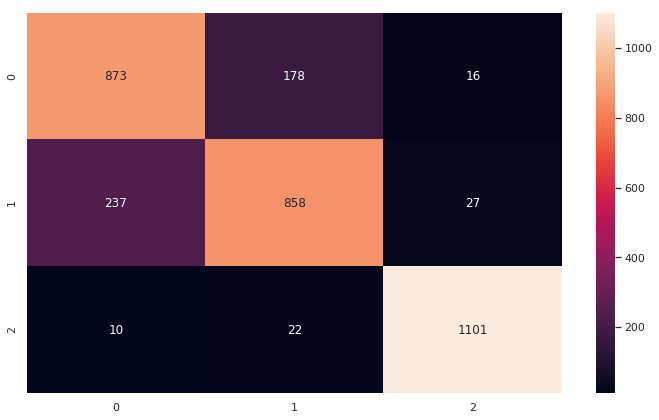

In [22]:
# Making a dataframe of the confusion matrix to plot it
df_cm = pd.DataFrame(cm, index=[i for i in classes], 
                    columns=[i for i in classes])
plt.figure(figsize=(12,7))
sn.heatmap(df_cm, annot=True, fmt='g')

plt.show()

## Distance Matrix

In [23]:
sub = np.concatenate((X, y.reshape(-1,1)), axis=1)
sub = pd.DataFrame(sub)
sub.sort_values(by=sub.iloc[:,-1].name, inplace=True)

In [24]:
sub.dropna(how='any', axis=0, inplace=True)


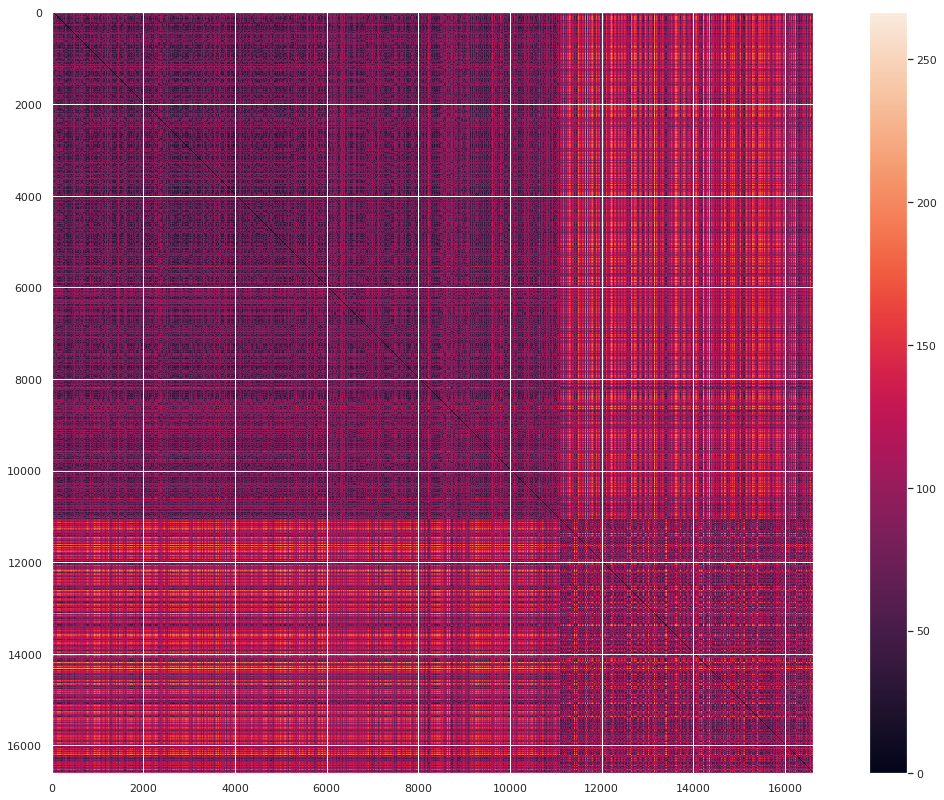

In [25]:
from scipy.spatial.distance import pdist, squareform
D = squareform(pdist(sub.values[:,:-1], metric='euclidean'))
#‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, 
#‘cosine’, ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, ‘kulsinski’, 
#‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, 
#‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’.

plt.figure(figsize=(20,14))
plt.imshow(D)
plt.colorbar()